# Plot all known ISBNs

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from common import CURRENT_DUMP_FILENAME, get_data_directory, label_groups
from tqdm.notebook import tqdm

from allisbns.dataset import (
    BinnedArray,
    CodeDataset,
    iterate_datasets,
    load_bencoded,
    unpack_data,
)
from allisbns.isbn import LAST_ISBN, TOTAL_ISBNS
from allisbns.plotting import BlockBinnedPlotter, get_default_colormap
from allisbns.rearrange import rearrange_to_blocks


%load_ext autoreload
%autoreload 2

In [2]:
input_path = get_data_directory() / CURRENT_DUMP_FILENAME
input_path.name

'aa_isbn13_codes_20251222T170326Z.benc.zst'

In [3]:
with open(input_path, "rb") as f:
    input_data = load_bencoded(f)

In [4]:
collections = [x.decode() for x in input_data]
print(collections)

['airitibooks', 'bloomsbury', 'cadal_ssno', 'cerlalc', 'chinese_architecture', 'duxiu_ssid', 'edsebk', 'gbooks', 'goodreads', 'hathi', 'huawen_library', 'ia', 'isbndb', 'isbngrp', 'kulturpass', 'libby', 'md5', 'motw', 'nexusstc', 'nexusstc_download', 'oclc', 'ol', 'ptpress', 'rgb', 'sciencereading', 'shukui', 'sklib', 'trantor', 'wanfang', 'zjjd']


In [5]:
dataset_iterator = iterate_datasets(input_data, fill_to_isbn=LAST_ISBN)

first = next(dataset_iterator)
_, *collections_to_merge = collections

with tqdm(total=len(collections_to_merge)) as progress:
    merged_packed_bits = np.packbits(first.unpack_codes())
    for collection, dataset in zip(collections_to_merge, dataset_iterator, strict=True):
        progress.set_description(f"Merging with '{collection}'")
        np.bitwise_or(
            merged_packed_bits,
            np.packbits(dataset.unpack_codes()),
            out=merged_packed_bits,
        )
        progress.update()

all_merged = CodeDataset.from_unpacked(np.unpackbits(merged_packed_bits)[:TOTAL_ISBNS])
all_merged

  0%|          | 0/29 [00:00<?, ?it/s]

CodeDataset(array([  141,     1,     2, ...,  2439,     1, 96764],
      shape=(49543746,), dtype=int32), bounds=(978000000000, 979999999999))

## Plot all known ISBNs

In [6]:
figure_size = (12, 12)

In [7]:
plotter_kwargs = {
    "block_width": int(1e5),
    "block_size": int(5e7),
    "aspect": 2,
}

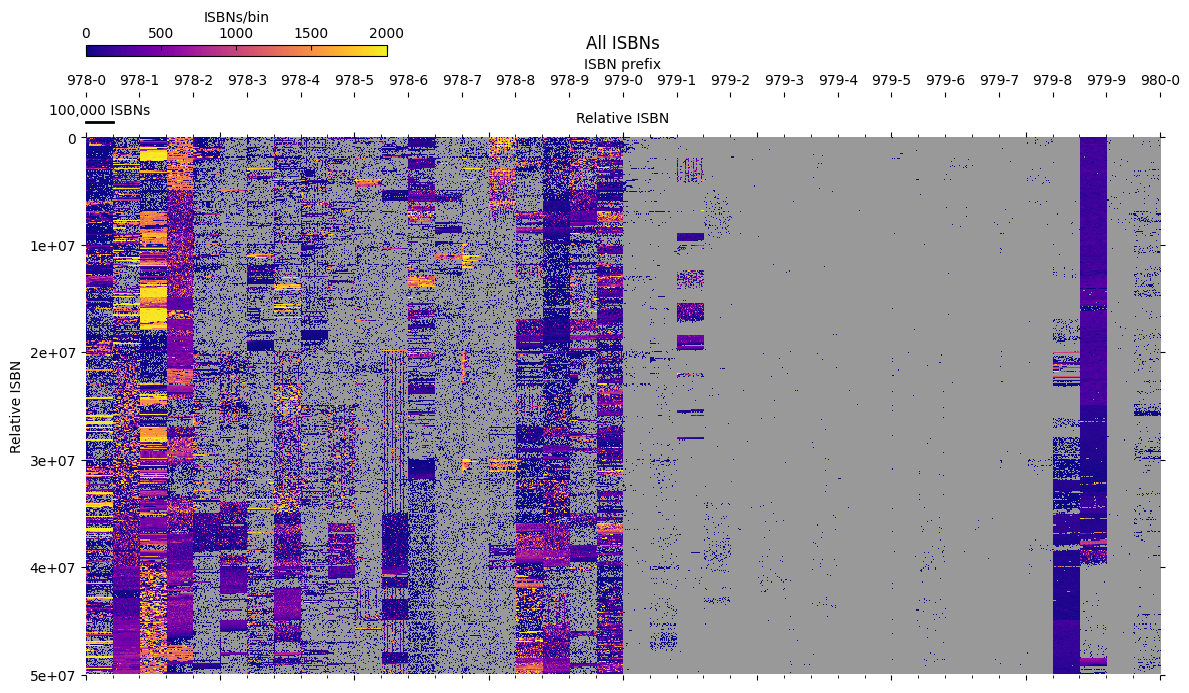

In [8]:
fig, ax = plt.subplots(figsize=figure_size)

all_binned = all_merged.bin(2000)

plotter = BlockBinnedPlotter(ax, all_binned.bin_size, **plotter_kwargs)
plotter.plot_bins(all_binned, vmin=0)

plt.title("All ISBNs")

plt.tight_layout()
plt.show()

## How full are bins with known ISBNs?

In [9]:
md5 = CodeDataset(unpack_data(input_data[b"md5"]), fill_to_isbn=LAST_ISBN)
md5

CodeDataset(array([     6,      1,      9, ...,  91739,      1, 531099],
      shape=(14754228,)), bounds=(978000000000, 979999999999))

In [10]:
f"{md5.count_filled_isbns() / all_merged.count_filled_isbns() * 100:.2f}%"

'16.94%'

In [11]:
md5_binned = md5.bin(bin_size=all_binned.bin_size)

fill_rates = BinnedArray(
    np.zeros_like(all_binned, dtype=np.float32),
    bin_size=all_binned.bin_size,
)

non_zero = all_binned.bins > 0
fill_rates.bins[~non_zero] = np.nan
fill_rates.bins[non_zero] = md5_binned.bins[non_zero] / all_binned.bins[non_zero] * 100
fill_rates

BinnedArray(array([58.24937, 71.24431, 71.96368, ...,      nan,      nan,      nan],
      shape=(1000000,), dtype=float32), bin_size=2000)

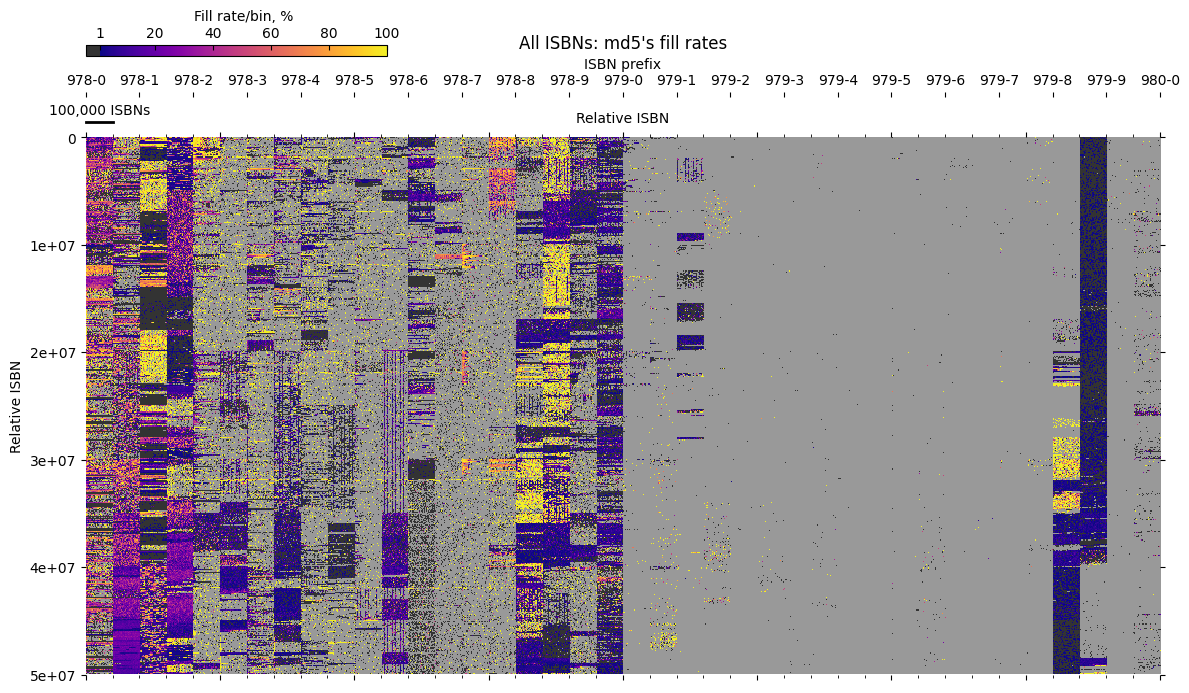

In [12]:
fig, ax = plt.subplots(figsize=figure_size)

plotter = BlockBinnedPlotter(ax, all_binned.bin_size, **plotter_kwargs)

colormap = get_default_colormap(under_color="0.2")
im = plotter.plot_bins(
    fill_rates, colormap=colormap, vmin=1, vmax=100, value_to_nan=None
)
im.colorbar.set_label("Fill rate/bin, %")

plt.title("All ISBNs: md5's fill rates")

plt.tight_layout()
plt.show()

## Plot idealistic fill rates

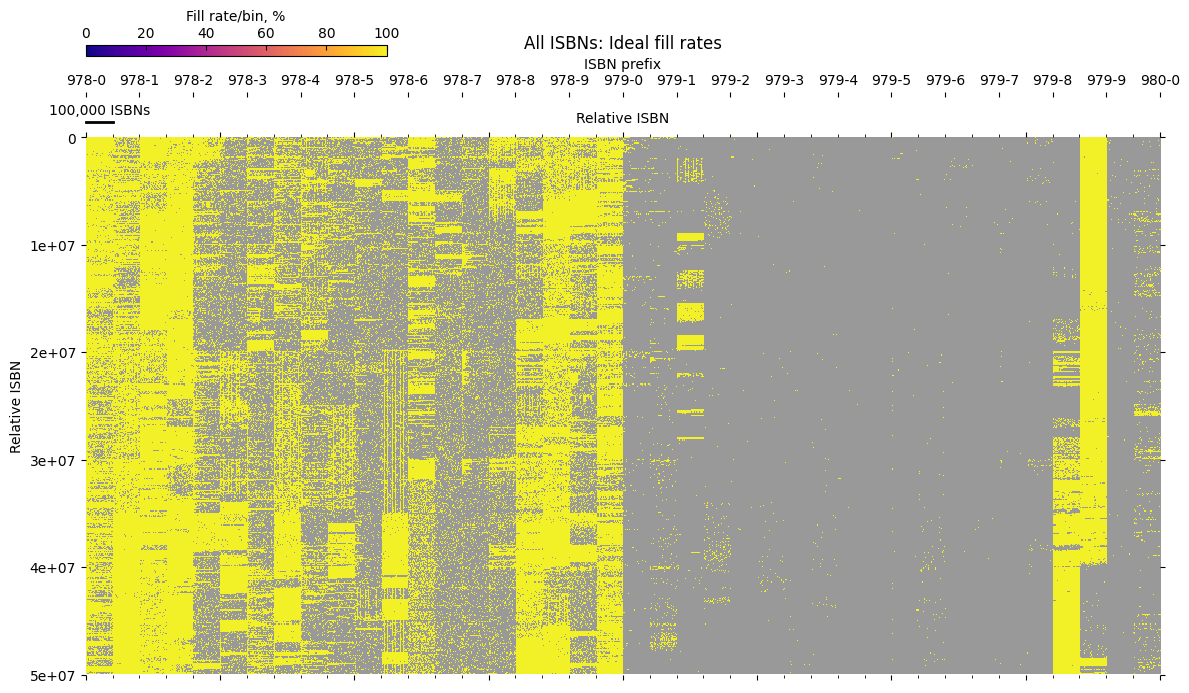

In [13]:
fig, ax = plt.subplots(figsize=figure_size)

plotter = BlockBinnedPlotter(ax, all_binned.bin_size, **plotter_kwargs)

ideal_fill_rates = BinnedArray(fill_rates.bins.copy(), fill_rates.bin_size)
ideal_fill_rates.bins[fill_rates.bins >= 0] = 100

im = plotter.plot_bins(ideal_fill_rates, vmin=0, vmax=100)
im.colorbar.set_label("Fill rate/bin, %")

plt.title("All ISBNs: Ideal fill rates")

plt.tight_layout()
plt.show()

## Highlight defined groups

In [14]:
group_labels = label_groups(all_binned.bins, all_binned.bin_size)
defined_group_mask = np.where(group_labels > 0, True, False)
defined_group_mask

array([ True,  True,  True, ..., False, False, False], shape=(1000000,))

In [15]:
defined_group_image = rearrange_to_blocks(
    defined_group_mask, all_binned.bin_size, plotter.block_width, plotter.block_size
)
defined_group_image

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]], shape=(500, 2000))

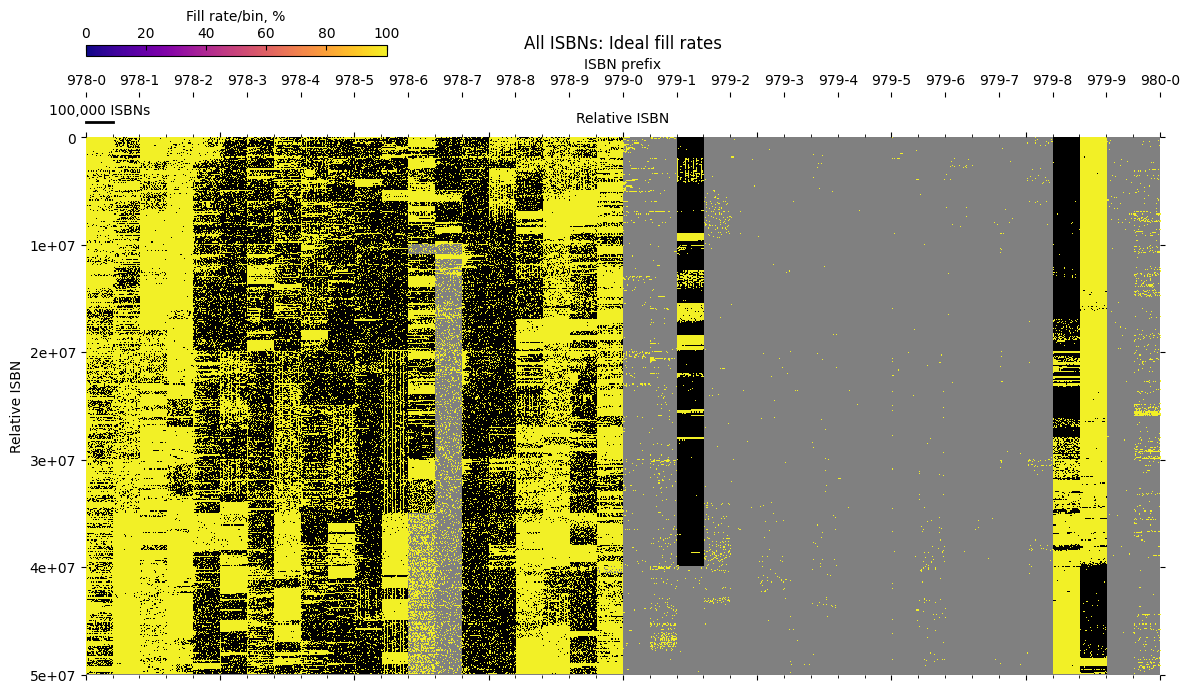

In [16]:
fig, ax = plt.subplots(figsize=figure_size)

plotter = BlockBinnedPlotter(ax, all_binned.bin_size, **plotter_kwargs)

ideal_fill_rates = BinnedArray(fill_rates.bins.copy(), fill_rates.bin_size)
ideal_fill_rates.bins[fill_rates.bins >= 0] = 100

plotter.plot_image(
    defined_group_image,
    colormap=mpl.colors.ListedColormap(["k"]),
    show_colorbar=False,
)

im = plotter.plot_bins(
    ideal_fill_rates, vmin=0, vmax=100, colormap=get_default_colormap(nan_color="none")
)
im.colorbar.set_label("Fill rate/bin, %")

ax.set_facecolor("0.5")

plt.title("All ISBNs: Ideal fill rates")

plt.tight_layout()
plt.show()